# Titanic v2

#### Import Libraries

In [96]:
# Standard Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import random as random

# Function to fill missing values
from sklearn.impute import SimpleImputer
from random import randint

# EDA/ Data Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import make_column_transformer

# Model Splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Scoring Metrics
from sklearn.metrics import *

#### Reading Data

In [2]:
# Read CSV file
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

#### Settings

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

#### Initial Analysis of Dataset

In [4]:
# Shape of Data
print(f"Shape of Train set (raw) : {train.shape}")
print(f"Shape of Test set (raw) : {test.shape}")

Shape of Train set (raw) : (891, 12)
Shape of Test set (raw) : (418, 11)


In [5]:
# Missing variable
print(f"Columns in Train but not in Test : {[col for col in train.columns if col not in test.columns]}")
print(f"Columns in Test but not in Train : {[col for col in test.columns if col not in train.columns]}")

Columns in Train but not in Test : ['Survived']
Columns in Test but not in Train : []


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


#### Number of missing values in train and test sets

In [8]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

`train` set contains 3 columns of missing values: `Cabin`>`Age`>`Embarked`

`test` set contains 3 columns of missing values: `Cabin`>`Age`>`Fare`

#### Descriptive Statistics about the training set

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
train.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"McCoy, Mr. Bernard",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


- `PassengerId` : drop it because it is useless.
- `Survived` : Approximately 38.3% of people survived.
- `Pclass` : categorical variable did ordinal encoding already.
- `Age` : Average age is approximately 29.6 years old. Youngest: 0 years old, Oldest: 80 years old.
- `SibSp` : Most number of siblings/ spouses is 8. Might need to remove outliers.
- `Parch` : Most number of parents/ children is 6. Might need to remove outliers.
- `Fare` : Median fare is 14 dollars, while average fair is 32 dollars, might need to apply log tranformation and remove outliers.
- `Name` : Every name is different and hence might need to separate out the titles.
- `Sex` : 2 different sexes only, use one-hot-encoding.
- `Ticket` : 681 different tickets, too many categories, might need to drop it.
- `Cabin` : A significant number of missing values, might not hold important information, drop it also can.
- `Embarked` : 2 missing values, impute with mode check the survival rate of the people, if varies significantly from port to port then use ordinal encoding, else one-hot-encoding.

In [12]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [13]:
test.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Louch, Mr. Charles Alexander",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


# Exploratory Data Analysis

## Univariate Analysis
Check distribution of every variable

In [14]:
# # Plot distributions for each variable
# numerical = ['SibSp' , 'Parch', 'Fare', 'PassengerId',  'Age']
# categorical = ['Cabin', 'Embarked', 'Pclass', 'Ticket', 'Sex']

# fig, axes = plt.subplots(5, 2, figsize = (15,25))
# plt.suptitle("Train vs Test Distribution")
# for predictor, position in zip(numerical, [0,1,2,3,4]):
    
#     """Distribution of train and test"""
    
#     b = sns.histplot(ax = axes[position, 0], data = train, x = predictor, color = 'darkblue', kde = True, 
#                      bins = 20)
#     axes[position, 0].set_title('Train')
    
#     a = sns.histplot(ax = axes[position, 1], data = test, x = predictor, color = 'orange', kde = True, 
#                      bins = 20)
#     axes[position, 1].set_title('Test')

#### Distribution of numerical variables
- `SibSp`, `Parch` and `Fare` does not have a normal distribution, might need to remove outliers and do a log transformation on them.
- `PassengerId`, no useful information to the data, drop them.
- `Age`, slightly skewed distribution, might need to normalize them.

In [15]:
# # Plot distributions for each variable
# fig, axes = plt.subplots(5, 2, figsize = (15,25))
# plt.suptitle("Train vs Test Distribution")
# for predictor, position in zip(categorical, [0,1,2,3,4]):
    
#     """Distribution of train and test"""
    
#     b = sns.countplot(ax = axes[position, 0], data = train, x = predictor, color = 'darkblue')
#     axes[position, 0].set_title('Train')
    
#     a = sns.countplot(ax = axes[position, 1], data = test, x = predictor, color = 'orange')
#     axes[position, 1].set_title('Test')

#### Distribution of categorical variables
- `Cabin` and `Tickets` have too many unique counts, drop them.
- `Embarked` , most people boarded at Southampton.
- `Pclass`, most people are in Pclass 3 followed by 1 then 2.
- `Sex`, more males than females.

In [16]:
# Drop 'Cabin', 'Tickets' and 'PassengerId'
train.drop(columns = ['Cabin', 'Ticket', 'PassengerId'], axis = 'columns', inplace = True)

# Save PassengerId for submission purposes
test_id = test[['PassengerId']]
test.drop(columns = ['Cabin', 'Ticket', 'PassengerId'], axis = 'columns', inplace = True)

In [17]:
# Shape of Data
print(f"Shape of Train set (raw) : {train.shape}")
print(f"Shape of Test set (raw) : {test.shape}")

Shape of Train set (raw) : (891, 9)
Shape of Test set (raw) : (418, 8)


## Basic Data Analysis
- `Age` : Fill missing values with median of titles and regroup them `AgeRange`
- Group `Parch` + `SibSp` + 1 = `familysize` vs survival rate
- Remove outliers for `Fare` and `familysize`
- `Name` : split into titles, check if titles have a relationship with `Survived`
- `Age` : check the age distribution across the different titles, if every title have a similar age range, then impute age missing values with title. If every title have very different age ranges, then impute age missing values with average age from each Pclass.

#### Names

In [18]:
# Extract titles from training data and test data
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Check the unique titles given
print(train['Title'].value_counts())
print(test['Title'].value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Col           2
Mlle          2
Sir           1
Jonkheer      1
Ms            1
Countess      1
Mme           1
Lady          1
Don           1
Capt          1
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dona        1
Dr          1
Name: Title, dtype: int64


In [19]:
# Group rare groups together, replace Ms with Miss
train['Title'] = train['Title'].replace(['Countess', 'Capt', 'Rev', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Sir', 'Dona', 'Mlle'], 
                       'others')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')


test['Title'] = test['Title'].replace(['Countess', 'Capt', 'Rev', 'Col', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 
                                       'Sir', 'Dona', 'Mlle'], 'others')
test['Title'] = test['Title'].replace('Ms', 'Miss')

# Check the unique titles given
print(train['Title'].value_counts())
print(test['Title'].value_counts())

Mr        517
Miss      183
Mrs       126
Master     40
others     25
Name: Title, dtype: int64
Mr        240
Miss       79
Mrs        72
Master     21
others      6
Name: Title, dtype: int64


In [20]:
# Check Survived
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.699454
2,Mr,0.156673
3,Mrs,0.793651
4,others,0.400000


In [21]:
# Create mapping
title_dict = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master' : 4, 'others': 5}

# Map
train['Title'] = train['Title'].map(title_dict).astype(int)
test['Title'] = test['Title'].map(title_dict).astype(int)

In [22]:
# Drop name in test and train
train.drop('Name', axis = 'columns', inplace = True)
test.drop('Name', axis = 'columns', inplace = True)

In [23]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,1
1,1,1,female,38.0,1,0,71.2833,C,3
2,1,3,female,26.0,0,0,7.9250,S,2
3,1,1,female,35.0,1,0,53.1000,S,3
4,0,3,male,35.0,0,0,8.0500,S,1


#### Age

In [24]:
# Shape of Data
print(f"Shape of Train set (raw) : {train.shape}")
print(f"Shape of Test set (raw) : {test.shape}")

Shape of Train set (raw) : (891, 9)
Shape of Test set (raw) : (418, 8)


In [25]:
# Check age across titles
print('Mean')
print(train[['Title', 'Age']].groupby(['Title'], as_index=False).mean())
print('Std')
print(train[['Title', 'Age']].groupby(['Title'], as_index=False).std())

Mean
   Title        Age
0      1  32.368090
1      2  21.816327
2      3  35.788991
3      4   4.574167
4      5  43.750000
Std
   Title        Age
0      1  12.708793
1      2  12.955909
2      3  11.437490
3      4   3.619872
4      5  12.796909


In [26]:
# Check age across titles
print('Median')
print(train[['Title', 'Age']].groupby(['Title'], as_index=False).median())
print('Std')
print(train[['Title', 'Age']].groupby(['Title'], as_index=False).std())

Median
   Title   Age
0      1  30.0
1      2  21.0
2      3  35.0
3      4   3.5
4      5  46.5
Std
   Title        Age
0      1  12.708793
1      2  12.955909
2      3  11.437490
3      4   3.619872
4      5  12.796909


In [27]:
# Check age across sex and pclass
print('Mean')
print(train[['Age', 'Pclass', 'Sex']].groupby(['Pclass', 'Sex'], as_index=False).mean())
print('Std')
print(train[['Age', 'Pclass', 'Sex']].groupby(['Pclass', 'Sex'], as_index=False).std())

Mean
   Pclass     Sex        Age
0       1  female  34.611765
1       1    male  41.281386
2       2  female  28.722973
3       2    male  30.740707
4       3  female  21.750000
5       3    male  26.507589
Std
   Pclass     Sex        Age
0       1  female  13.612052
1       1    male  15.139570
2       2  female  12.872702
3       2    male  14.793894
4       3  female  12.729964
5       3    male  12.159514


Seen from the two codes, the standard deviation and hence variance of the age is smaller if I impute the missing values according to the titles and not the Pclass and Sex. Hence, I will impute missing values of age by median of titles (not mean because distribution of age is slightly skewed).

In [28]:
# Shape of Data
print(f"Shape of Train set (raw) : {train.shape}")
print(f"Shape of Test set (raw) : {test.shape}")

Shape of Train set (raw) : (891, 9)
Shape of Test set (raw) : (418, 8)


In [29]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
Title         0
dtype: int64

In [30]:
# index of missing age
index_NA_age = list(train["Age"][train["Age"].isnull()].index)

# impute table
impute_table = train[['Title', 'Age']].groupby(['Title'], as_index=False).median()
impute_table_mean = train[['Title', 'Age']].groupby(['Title'], as_index=False).mean()
impute_table_std = train[['Title', 'Age']].groupby(['Title'], as_index=False).std()

# impute with missing value
for i in range(len(train)):
    if train['Age'].iloc[i] != train['Age'].iloc[i]:
        title_v = train.iloc[i]['Title'] # title of missing value
        #print(f"{title_v} -> value of Title at index {i}")
    
        avg = impute_table_mean.iloc[title_v-1, 1] # mean age
        sd = impute_table_std.iloc[title_v-1, 1] # sd age
        lower = (avg - sd).astype(int)
        upper = (avg + sd).astype(int) 
    
        v_toImpute = random.randint(lower, upper)
    
        train['Age'].iloc[i] = v_toImpute

/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [31]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
Title       0
dtype: int64

In [32]:
test.isna().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
Title        0
dtype: int64

In [33]:
# fill missing values of age for test
# index of missing age
index_NA_age = list(test["Age"][test["Age"].isnull()].index)

# impute table
impute_table = test[['Title', 'Age']].groupby(['Title'], as_index=False).median()
impute_table_mean = test[['Title', 'Age']].groupby(['Title'], as_index=False).mean()
impute_table_std = test[['Title', 'Age']].groupby(['Title'], as_index=False).std()

# impute with missing value
for i in range(len(test)):
    if test['Age'].iloc[i] != test['Age'].iloc[i]:
        title_v = test.iloc[i]['Title'] # title of missing value
        #print(f"{title_v} -> value of Title at index {i}")
    
        avg = impute_table_mean.iloc[title_v-1, 1] # mean age
        sd = impute_table_std.iloc[title_v-1, 1] # sd age
        lower = (avg - sd).astype(int)
        upper = (avg + sd).astype(int) 
    
        v_toImpute = random.randint(lower, upper)
    
        test['Age'].iloc[i] = v_toImpute

In [34]:
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
Title       0
dtype: int64

#### Split Age Range

In [35]:
# Split into Age Range
train['AgeRange'] = pd.cut(train['Age'], 5)
train[['AgeRange', 'Survived']].groupby(['AgeRange'], as_index=False).mean().sort_values(by='AgeRange', 
                                                                                         ascending=True)

,AgeRange,Survived
0,"(0.34, 16.336]",0.555556
1,"(16.336, 32.252]",0.364269
2,"(32.252, 48.168]",0.338403
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [36]:
# Convert Age to age range for train
train.loc[(train['Age'] <= 16), 'Age'] = 0
train.loc[(train['Age'] <= 32)  & (train['Age'] > 16), 'Age'] = 1
train.loc[(train['Age'] <= 48)  & (train['Age'] > 32), 'Age'] = 2
train.loc[(train['Age'] <= 64)  & (train['Age'] > 48), 'Age'] = 3
train.loc[(train['Age'] > 64), 'Age'] = 4

train['Age'] = train['Age'].astype(int)

In [37]:
# Convert Age to age range for test
test.loc[(test['Age'] <= 16), 'Age'] = 0
test.loc[(test['Age'] <= 32)  & (test['Age'] > 16), 'Age'] = 1
test.loc[(test['Age'] <= 48)  & (test['Age'] > 32), 'Age'] = 2
test.loc[(test['Age'] <= 64)  & (test['Age'] > 48), 'Age'] = 3
test.loc[(test['Age'] > 64), 'Age'] = 4

test['Age'] = test['Age'].astype(int)

In [38]:
# Drop 'AgeRange'
train.drop('AgeRange', axis = 'columns', inplace = True)

In [39]:
# Create familysize
train['familysize'] = train['Parch'] + train['SibSp'] + 1
test['familysize'] = test['Parch'] + test['SibSp'] + 1

# Drop Parch and SibSp
train.drop(columns = ['SibSp', 'Parch'], axis = 'columns', inplace = True)
test.drop(columns = ['SibSp', 'Parch'], axis = 'columns', inplace = True)

In [40]:
# Shape of Data
print(f"Shape of Train set (raw) : {train.shape}")
print(f"Shape of Test set (raw) : {test.shape}")

Shape of Train set (raw) : (891, 8)
Shape of Test set (raw) : (418, 7)


In [41]:
train.shape

(891, 8)

In [42]:
# Remove outliers
def idxOutliersIQR(df, features):
    idxOutliers = {} # feature: list of outlier indexes
    
    for feature in features:
        f_idx = df.columns.get_loc(feature)
        idxOutliers[feature] = []
        
        quantile_25 = np.percentile(df[feature], 25)
        quantile_75 = np.percentile(df[feature], 75)
        
        iqr = quantile_75 - quantile_25
        
        lower = max(quantile_25 - 1.5*iqr, 0)
        upper = quantile_75 + 1.5*iqr
        
        print(f"{feature}'s lower bound is {lower}")
        print(f"{feature}'s upper bound is {upper}")
        
        for i in range(len(df)):
            if (df.iloc[i, f_idx] < lower) or (df.iloc[i, f_idx] > upper):
                idxOutliers[feature].append(i)
                
    return idxOutliers

In [43]:
idxOutliers = idxOutliersIQR(train, ['Fare', 'familysize'])

Fare's lower bound is 0
Fare's upper bound is 65.6344
familysize's lower bound is 0
familysize's upper bound is 3.5


In [44]:
def generateIdx(d): # d : dict of idxOutliersIQR
    idxOutliersRemoved = []
    for key, value in d.items():
        for v in value:
            if v not in idxOutliersRemoved:
                idxOutliersRemoved.append(v)
    return idxOutliersRemoved

In [45]:
idxOutRemoved = generateIdx(idxOutliers)

In [46]:
# drop indexes
train.drop(index = idxOutRemoved, axis = 'index', inplace = True)

In [47]:
# Shape of Data
print(f"Shape of Train set (raw) : {train.shape}")
print(f"Shape of Test set (raw) : {test.shape}")

Shape of Train set (raw) : (704, 8)
Shape of Test set (raw) : (418, 7)


In [48]:
train.describe()

,Survived,Pclass,Age,Fare,Title,familysize
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000
mean,0.342330,2.448864,1.387784,16.484848,1.583807,1.399148
std,0.474827,0.752577,0.799302,13.129525,0.978471,0.683934
min,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,2.000000,1.000000,7.854200,1.000000,1.000000
50%,0.000000,3.000000,1.000000,10.500000,1.000000,1.000000
75%,1.000000,3.000000,2.000000,23.250000,2.000000,2.000000
max,1.000000,3.000000,4.000000,63.358300,5.000000,3.000000


In [49]:
test.describe()

,Pclass,Age,Fare,Title,familysize
count,418.000000,418.000000,417.000000,418.000000,418.000000
mean,2.265550,1.366029,35.627188,1.741627,1.839713
std,0.841838,0.817960,55.907576,1.006091,1.519072
min,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1.000000,1.000000,7.895800,1.000000,1.000000
50%,3.000000,1.000000,14.454200,1.000000,1.000000
75%,3.000000,2.000000,31.500000,2.000000,2.000000
max,3.000000,4.000000,512.329200,5.000000,11.000000


## Feature Engineering
- `Fare` : apply log transformation and split into ranges
- `Embarked` : change to OHE

#### Fare

[Text(0.5, 1.0, 'Test')]

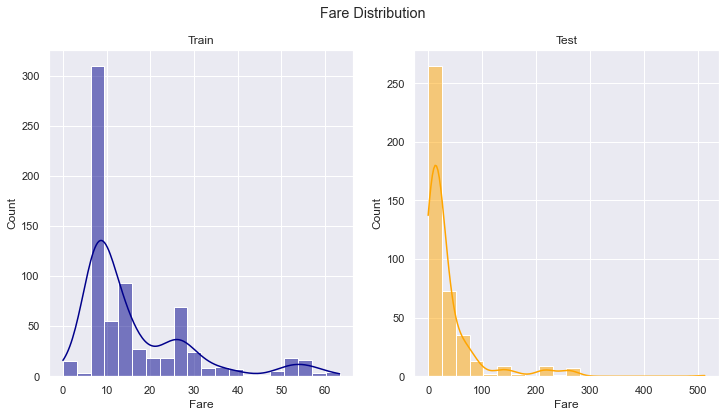

In [50]:
# Check distribution
sns.set(rc = {'figure.figsize':(12,6)})
fig, axes = plt.subplots(1,2)
plt.suptitle("Fare Distribution")
sns.histplot(x = train['Fare'], kde = True, bins = 20, ax = axes[0], color = 'darkblue').set(title = "Train")
sns.histplot(x = test['Fare'], kde = True, bins = 20, ax = axes[1], color = 'orange').set(title = "Test")

In [51]:
# impute fare with median
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [52]:
# Split log_fare into ranges
train['fare_range'] = pd.cut(train['Fare'], 5)
train[['fare_range', 'Survived']].groupby(['fare_range'], as_index=False).mean().sort_values(by='fare_range', 
                                                                                         ascending=True)

,fare_range,Survived
0,"(-0.0634, 12.672]",0.232376
1,"(12.672, 25.343]",0.391026
2,"(25.343, 38.015]",0.527273
3,"(38.015, 50.687]",0.357143
4,"(50.687, 63.358]",0.682927


In [53]:
# # Apply log transformation
# train['log_fare'] = np.log1p(train['Fare'])
# test['log_fare'] = np.log1p(test['Fare'])

# # Drop 'Fare'
# train.drop('Fare', axis = 'columns', inplace = True)
# test.drop('Fare', axis = 'columns', inplace = True)

In [54]:
# # Check distribution
# sns.set(rc = {'figure.figsize':(12,6)})
# fig, axes = plt.subplots(1,2)
# plt.suptitle("Log Fare Distribution")
# sns.histplot(x = train['log_fare'], kde = True, bins = 20, ax = axes[0], color = 'darkblue').set(title = "Train")
# sns.histplot(x = test['log_fare'], kde = True, bins = 20, ax = axes[1], color = 'orange').set(title = "Test")

For this version I will not do a log transformation and just categorize by fare. However, in the next version, it is worth checking if log_fare will do a better job. Uncomment the codes above to see the difference.

In [55]:
# Convert Fare to fare range for train
train.loc[(train['Fare'] <= 13), 'Fare'] = 0
train.loc[(train['Fare'] <= 25)  & (train['Fare'] > 13), 'Fare'] = 1
train.loc[(train['Fare'] <= 38)  & (train['Fare'] > 25), 'Fare'] = 2
train.loc[(train['Fare'] <= 51)  & (train['Fare'] > 38), 'Fare'] = 3
train.loc[(train['Fare'] > 51), 'Fare'] = 4

train['Fare'] = train['Fare'].astype(int)

In [56]:
# Convert Fare to fare range for test
test.loc[(test['Fare'] <= 13), 'Fare'] = 0
test.loc[(test['Fare'] <= 25)  & (test['Fare'] > 13), 'Fare'] = 1
test.loc[(test['Fare'] <= 38)  & (test['Fare'] > 25), 'Fare'] = 2
test.loc[(test['Fare'] <= 51)  & (test['Fare'] > 38), 'Fare'] = 3
test.loc[(test['Fare'] > 51), 'Fare'] = 4

test['Fare'] = test['Fare'].astype(int)

In [57]:
# drop fare_range
train.drop('fare_range', axis = 'columns', inplace = True)

#### Sex

In [62]:
# Use OHE
sex_dict = {'male' : 0, 'female' : 1}

# Map across train or test data
train['sex_ohe'] = train['Sex'].map(sex_dict)
test['sex_ohe'] = test['Sex'].map(sex_dict)

# Remove ['Sex'] from train and test
train.drop(['Sex'], axis = 'columns', inplace = True)
test.drop(['Sex'], axis = 'columns', inplace = True)

#### Embarked

In [63]:
# Use dummies to encode it
train_embarked_dummies = pd.get_dummies(train['Embarked'])
test_embarked_dummies = pd.get_dummies(test['Embarked'])

train = pd.concat([train, train_embarked_dummies], axis = 'columns')
test = pd.concat([test, test_embarked_dummies], axis = 'columns')

# Drop embarked
train.drop(['Embarked'], axis = 'columns', inplace = True)
test.drop(['Embarked'], axis = 'columns', inplace = True)

In [66]:
test.head()

,Pclass,Age,Fare,Title,familysize,sex_ohe,C,Q,S
0,3,2,0,1,1,0,0,1,0
1,3,2,0,3,2,1,0,0,1
2,2,3,0,1,1,0,0,1,0
3,3,1,0,1,1,0,0,0,1
4,3,1,0,3,3,1,0,0,1


In [67]:
train.head()

,Survived,Pclass,Age,Fare,Title,familysize,sex_ohe,C,Q,S
0,0,3,1,0,1,2,0,0,0,1
2,1,3,1,0,2,1,1,0,0,1
3,1,1,2,4,3,2,1,0,0,1
4,0,3,2,0,1,1,0,0,0,1
5,0,3,1,0,1,1,0,0,1,0


# Split Data

In [71]:
X_train, X_test, y_train, y_test = train_test_split(train.iloc[:, 1:], train.iloc[:, 0], test_size = 0.2,
                                                    random_state = 26)

In [98]:
# Models
dt = DecisionTreeClassifier(random_state = 26)
rf = RandomForestClassifier()
knn = KNeighborsClassifier(n_neighbors = 10)
xgb = XGBClassifier(booster = 'gbtree')
svc = SVC()

In [73]:
# Print scores
def print_score(test, pred):
    print(f"Accuracy : {round(accuracy_score(test, pred), 3)}%")
    print(f"Recall : {round(recall_score(test, pred), 3)}%")
    print(f"Precision : {round(precision_score(test, pred), 3)}%")
    print(f"f1 Score : {round(f1_score(test, pred), 3)}%")

# Decision Tree

In [74]:
# fitting the model
dt.fit(X_train, y_train)

# predictions
y_pred = dt.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.78%
Recall : 0.581%
Precision : 0.658%
f1 Score : 0.617%


In [75]:
# Hyperparameter tuning for DT
dt_grid = {'max_depth': [3,4,5,6,7,8], 'min_samples_leaf': [2,4,6,8,10], 'min_samples_split':
       [2,3,4,5,6,7,8,9,10]}

dt_cv = GridSearchCV(DecisionTreeClassifier(), dt_grid, cv=10, n_jobs=-1, verbose=1)

In [76]:
dt_cv.fit(X_train, y_train)

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [2, 4, 6, 8, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=1)

In [77]:
dt_cv.best_params_

{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4}

In [78]:
best_dt = dt_cv.best_estimator_

In [79]:
# fit the model
best_dt.fit(X_train, y_train)

# predictions
y_pred = best_dt.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.801%
Recall : 0.698%
Precision : 0.667%
f1 Score : 0.682%


# Random Forest

In [80]:
# fit the model
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.801%
Recall : 0.651%
Precision : 0.683%
f1 Score : 0.667%


In [81]:
# Hyperparameter tuning for rf
rf_grid = {'criterion':['gini', 'entropy', 'log_loss'], 'max_depth': [3,4,5,6,7,8], 'min_samples_leaf': [2,3,4,5,6,7,8,9,10],
           'min_samples_split': [2,3,4,5,6,7,8,9,10]}

rf_cv = GridSearchCV(RandomForestClassifier(), rf_grid, cv=10, n_jobs=-1, verbose=1)

In [82]:
# fit the model
rf_cv.fit(X_train, y_train)

Fitting 10 folds for each of 1458 candidates, totalling 14580 fits


/Users/cheongkyler/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.81716792 0.81005639 0.80827068 ...        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             verbose=1)

In [83]:
best_rf = rf_cv.best_estimator_

In [84]:
# fit data
best_rf.fit(X_train, y_train)

# predict data
y_pred = best_rf.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.816%
Recall : 0.698%
Precision : 0.698%
f1 Score : 0.698%


In [85]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

# K-Nearest Neighbors

In [86]:
# fit model
knn.fit(X_train, y_train)

# predictions
y_pred = knn.predict(X_test)

# model score
print_score(y_test, y_pred)

Accuracy : 0.794%
Recall : 0.605%
Precision : 0.684%
f1 Score : 0.642%


In [87]:
# Hyperparameter tuning in knn
knn_grid = {'n_neighbors' : list(range(3,100)), 'p' : [1,2]}

knn_cv = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=10, n_jobs=-1, verbose=1)

In [88]:
knn_cv.fit(X_train, y_train)

Fitting 10 folds for each of 194 candidates, totalling 1940 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, 32, ...],
                         'p': [1, 2]},
             verbose=1)

In [89]:
best_knn = knn_cv.best_estimator_

In [90]:
# fit model
best_knn.fit(X_train, y_train)

# predictions
y_pred = best_knn.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.809%
Recall : 0.674%
Precision : 0.69%
f1 Score : 0.682%


# XGBClassifier

In [91]:
# fit data
xgb.fit(X_train, y_train)

# predictions
y_pred = xgb.predict(X_test)

# print scores
print_score(y_test, y_pred)

Accuracy : 0.801%
Recall : 0.558%
Precision : 0.727%
f1 Score : 0.632%


In [92]:
# Hyperparameter tuning in xgb
xgb_grid = {'eta': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8], "learning_rate": [0.01, 0.05, 0.1], "n_estimators": 
            [100, 500, 1000]}

xgb_cv = GridSearchCV(XGBClassifier(booster = 'gbtree'), xgb_grid, cv=10, n_jobs=-1, verbose=1)

In [93]:
xgb_cv.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=

In [94]:
best_xgb = xgb_cv.best_estimator_

In [95]:
# fit model
best_xgb.fit(X_train, y_train)

# predictions
y_pred = best_xgb.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.816%
Recall : 0.628%
Precision : 0.73%
f1 Score : 0.675%


# SVC

In [99]:
# fit data
svc.fit(X_train, y_train)

# predictions
y_pred = svc.predict(X_test)

# print scores
print_score(y_test, y_pred)

Accuracy : 0.809%
Recall : 0.698%
Precision : 0.682%
f1 Score : 0.69%


In [101]:
# Hyperparameter tuning in svc
svc_grid = {'kernel': ['rbf', 'poly', 'sigmoid'], 'degree':[2,3,4,5,6,7], 'gamma': np.linspace(0,1,10).tolist()}

svc_cv = GridSearchCV(SVC(), svc_grid, cv=10, n_jobs=-1, verbose=1)

In [102]:
svc_cv.fit(X_train, y_train)

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'degree': [2, 3, 4, 5, 6, 7],
                         'gamma': [0.0, 0.1111111111111111, 0.2222222222222222,
                                   0.3333333333333333, 0.4444444444444444,
                                   0.5555555555555556, 0.6666666666666666,
                                   0.7777777777777777, 0.8888888888888888,
                                   1.0],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [103]:
best_svc = svc_cv.best_estimator_

In [105]:
# fit model
best_svc.fit(X_train, y_train)

# predictions
y_pred = best_svc.predict(X_test)

# print score
print_score(y_test, y_pred)

Accuracy : 0.801%
Recall : 0.721%
Precision : 0.66%
f1 Score : 0.689%


# Evaluation

Purely on accuracy score, best_rf and best_xgb have the highest accuracy of 0.816%

**best_rf : 0.816**

**best_xgb : 0.816**

**best_knn : 0.809**

**best_svc : 0.801**

**best_dt : 0.801**

In [110]:
# use best_rf to predict on test set
y_predictions = best_xgb.predict(test)

In [111]:
y_predictions = pd.DataFrame(y_predictions)

In [112]:
output = pd.DataFrame({'PassengerId': test_id.iloc[:, 0], 'Survived': y_predictions.iloc[:, 0]})

In [113]:
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
